# Predicting house prices

---

We were considering classification problems, where the goal was to predict a single discrete label of an input data point. Another common type of machine learning problem is *regression*, which consists of predicting a continuous value instead instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

### The Boston housing price data set

---

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

#### Import libraries and load data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models 
from keras import layers 
from keras.utils import to_categorical 
from keras.datasets import boston_housing

Using TensorFlow backend.


In [6]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape)
print(train_targets.shape)
print("Sample data:", train_data[0])
print("Sample price:", train_targets[0])

(404, 13)
(404,)
Sample data: [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
Sample price: 15.2


The data comprises 13 features:

1. Per capita crime rate. 
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town. 
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). 
5. Nitric oxides concentration (parts per 10 million). 
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940. 
8. Weighted distances to five Boston employment centres. 
9. Index of accessibility to radial highways. 
10. Full-value property-tax rate per $10,000. 
11. Pupil-teacher ratio by town. 
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town. 
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars.

#### Prepare the data

It is problematic to feed into a neural network values that all take different ranges. The network might be able to automatically adapt, but it would make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: 

For each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation.

In [14]:
# Calculates the mean and std for each of the data features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
print(mean)
print(std)

# Subsctract the mean
train_data -= mean
test_data -= mean

# Divide by the standard deviation
train_data /= std
test_data /= std

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization. 

Normalizing using the training parameters only is best as sampling errors may negatively bias the predictions: it makes sense to use the means and variances from the training data, since it's what the model was trained on. The model approximates a mapping from data standardized by the training data's mean and variance, so using the test data's mean and variance would give you inaccurate results.

In [30]:
# Build the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))

    # The models ends with one layer, and no activation
    model.add(layers.Dense(1))

    # Using mean squared error function: best for regression problems
    # For metric, using the mean absolute error: absolute error of the difference between 
    # the prediction and the target
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
    
    return model

#### Validating using K-fold validation

When you have small data sets, using a validation with a slice of the data may change validation scores depending on which data points were chosen for the validation and which for training. This prevents us from reliably evaluating the model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

![k-fold](images/k-fold.png)

In [82]:
# K-fold validation

k = 4
num_val_samples = len(train_data) // k
print("Validation samples:", num_val_samples)

all_mae_histories = []

num_epochs = 500

for i in range(k):
    print("Processing fold: ", i)
    
    # Prepare the validation data
    val_data = train_data[i * (num_val_samples) : (i+1) * num_val_samples]
    val_targets = train_targets[i * (num_val_samples) : (i+1) * num_val_samples]
    
    # Prepare the train data
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                         train_targets[(i+1)*num_val_samples:]], axis = 0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs,
                        validation_data = (val_data, val_targets),
                        batch_size = 20, verbose = 0)
    all_mae_histories.append(history.history['val_mean_absolute_error'])

Validation samples: 101
Processing fold:  0
Processing fold:  1
Processing fold:  2
Processing fold:  3


Average validation:  2.635614234992773


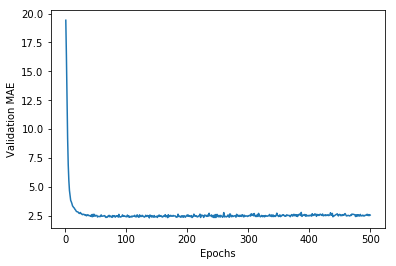

In [98]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print("Average validation: ", np.mean(average_mae_history))
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

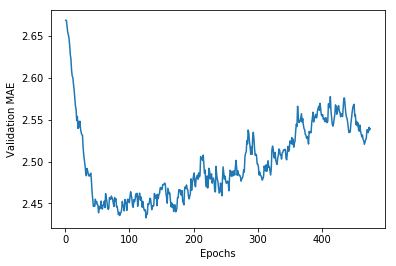

In [93]:
# To visualize more easily: 
# Omit the first data points, which are on a different scale from the rest of the curve.
# Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.
def smooth_curve(points, factor=0.9): 
    smoothed_points = [] 
    for point in points: 
        if smoothed_points: 
            previous = smoothed_points[-1] 
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: 
            smoothed_points.append(point) 
    
    return smoothed_points 

        
smooth_mae_history = smooth_curve(average_mae_history[25:]) 

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE')
plt.show()

In [97]:
# Train after 80 epochs and validate on the test data

model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 10, verbose = 0)

test_mse, test_mae = model.evaluate(test_data, test_targets)

print("Mse: {0} Mae: {1}".format(test_mse, test_mae))

102/102 [==============================] - 1s 6ms/step
Mse: 16.30868320839078 Mae: 2.5702745774213005
